In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state = 0)

In [3]:
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

In [5]:
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)

print("Test score:{:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score:0.95


# 前処理を行う際のパラメータ選択

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100],
              "gamma": [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(SVC(), param_grid = param_grid, cv = 5)
grid.fit(X_train_scaled, y_train)

print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


ここで、データをスケール変換する際に、訓練セットの全てのデータを使い、それを用いて交差検証を用いてグリッドサーチを行った。

ここで、スケール変換をする際に、交差検証の時にテストセットとなりうるデータの情報をすでに使ってしまっている。

つまり、交差検証時に作られるモデルにとって、テストデータは全く新しいものではない。

In [9]:
import mglearn
import matplotlib.pyplot as plt

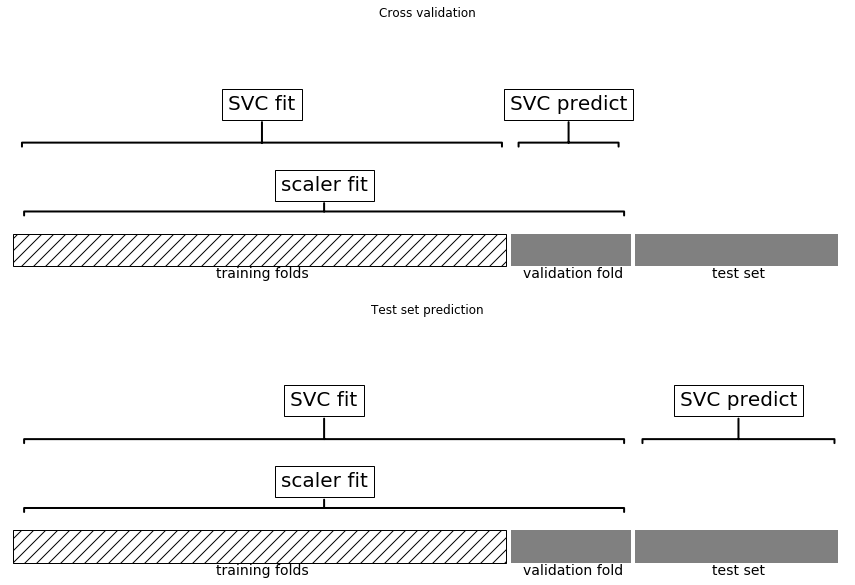

In [11]:
mglearn.plots.plot_improper_processing()
plt.show()

# パイプラインの構築

パイプラインを用いることによって、データの情報リークをなくすことができる

In [12]:
from sklearn.pipeline import Pipeline

In [13]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [14]:
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


パイプラインのscoreメソッドを用いると，まずテストデータをscalerで変換し，SVMのscoreメソッドを変換されたデータで呼び出す．

# パイプラインを用いたグリッドサーチ

この操作をする場合には、どのステップでどのパラメータを用いるのかという情報を付け足さねければならない。

In [16]:
param_grid = {"svm__C": [0.001, 0.01, 0.1, 1, 10, 100],
              "svm__gamma": [0.001, 0.01, 0.1, 1, 10, 100]}

あとは普通のグリッドサーチを行うだけである。

In [18]:
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5)
grid.fit(X_train, y_train)

print("Best cross-validation-score: {:.2f}".format(grid.best_score_))
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parametor: {}".format(grid.best_params_))


Best cross-validation-score: 0.98
Test score: 0.97
Best parametor: {'svm__C': 1, 'svm__gamma': 1}


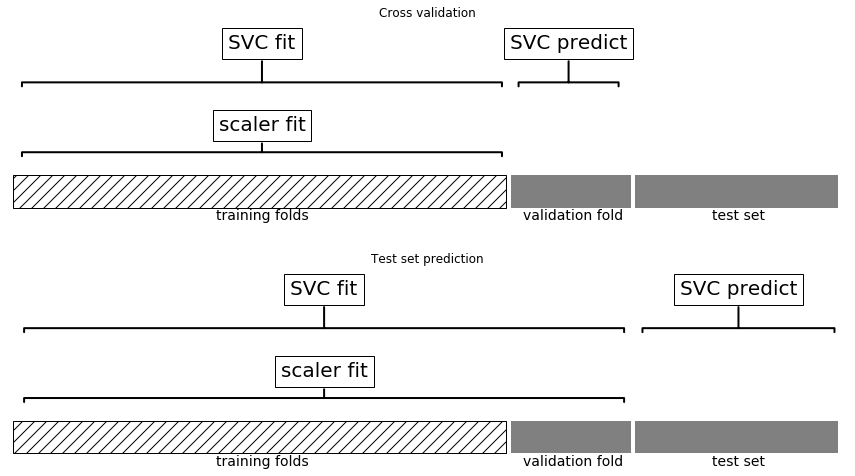

In [19]:
mglearn.plots.plot_proper_processing()
plt.show()

# 汎用パイプラインインターフェイス

Pipelineクラスが適用できるのは、前処理とクラス分類に限られてるわけではない。

In [20]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed, y)
        
    self.step[-1][1].fit(X_transformed, y)
    return self

In [21]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
        
    return self.steps[-1][1].predict(X_transformed)

## make_pipelineによる簡便なパイプライン生成

In [23]:
from sklearn.pipeline import make_pipeline
#通常の文法
pipe_long = Pipeline([("sclaer", MinMaxScaler()), ("svm", SVC(C = 100))])
#短縮した文法
pipe_short = make_pipeline(MinMaxScaler, SVC(C = 100))

In [24]:
print("Pipeline steps:\n{}".format(pipe_long.steps))

Pipeline steps:
[('sclaer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svm', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [25]:
print("Pipeline steps:\n{}".format(pipe_short.steps))

Pipeline steps:
[('type', <class 'sklearn.preprocessing.data.MinMaxScaler'>), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components = 2), StandardScaler())

print("Pipeline steps:\n{}".format(pipe.steps))

Pipeline steps:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


## ステップ属性へのアクセス

In [27]:
pipe.fit(cancer.data)

components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


## GridSearchCV内のパイプライン属性へのアクセス

In [28]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [29]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
print("Best estimator:\n{}".format(grid.best_estimator_))

Best estimator:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


In [33]:
print("Logistic regression step:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [34]:
print("Logistic regression coefficients:\n{}".format(
    grid.best_estimator_.named_steps["logisticregression"].coef_))

Logistic regression coefficients:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


# 前処理ステップとモデルパラメータに対するグリッドサーチ

データのスケール変換、多項式特徴量の生成、リッジ回帰の３ステップのpipelineを見てみる。

In [36]:
from sklearn.datasets import load_boston

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(
    boston.data, boston.target, random_state = 0)

In [37]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [38]:
param_grid = {"polynomialfeatures__degree": [1, 2, 3],
              "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

In [39]:
grid = GridSearchCV(pipe, param_grid = param_grid, cv = 5, n_jobs = 1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

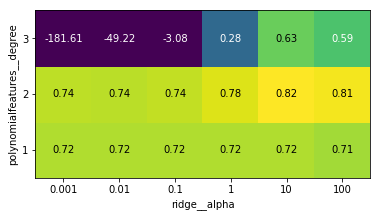

In [40]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)
plt.show()

In [41]:
print("Best parameters: {}".format(grid.best_params_))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


In [42]:
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Test-set score: 0.77


In [43]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


多項式特徴量を用いないと、精度はガクンと下がる。

Ridgeには多項式特徴量が必要になってくることがわかった。

# グリッドサーチによるモデルの選択

In [45]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [46]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
               'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              
              {'classifier': [RandomForestClassifier(n_estimators=100)],
               'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98
